## Improved Model 

In [1]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

from keras import models, layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# load MNIST dataset

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
len(train_images)

60000

In [4]:
# rescale pixel values from range [0, 255] to [0, 1]
rescaled_train_images= train_images.astype('float32') / 255. 
rescaled_test_images= test_images.astype('float32') / 255.

# reshape for tenserflow backend
reshaped_train_images = rescaled_train_images.reshape((len(train_images), 28, 28, 1))
reshaped_test_images = rescaled_test_images.reshape((len(test_images), 28, 28, 1))

# converts a class vector (integers) to binary class matrix
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

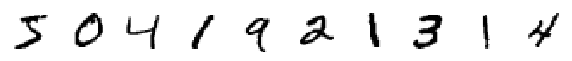

In [5]:
# show sample train images without noise
_, ax = plt.subplots(1, 10, figsize=(10,10))

for i in range(0, 10):
    ax[i].axis('off')
    ax[i].imshow(reshaped_train_images[i].reshape(28,28), cmap=plt.cm.binary)

In [6]:
# add noise to training and test dataset

noise_factor = 0.5

train_images_noisy = reshaped_train_images + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=reshaped_train_images.shape)
test_images_noisy = reshaped_test_images + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=reshaped_test_images.shape)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

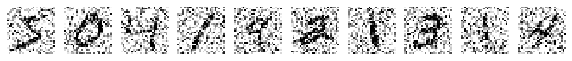

In [7]:
# show sample train images with noise
_, ax = plt.subplots(1, 10, figsize=(10,10))

for i in range(0, 10):
    ax[i].axis('off')
    ax[i].imshow(train_images_noisy[i].reshape(28,28), cmap=plt.cm.binary)

## Adding Denoising Convolutional Autoencoder

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

# encoder

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the autoencoder model
autoencoder.fit(train_images_noisy, reshaped_train_images,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images_noisy,reshaped_test_images))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 48s 792us/step - loss: 0.0520 - val_loss: 0.0387
Epoch 2/50
60000/60000 [==============================] - 50s 827us/step - loss: 0.0354 - val_loss: 0.0325
Epoch 3/50
60000/60000 [==============================] - 50s 835us/step - loss: 0.0315 - val_loss: 0.0303
Epoch 4/50
60000/60000 [==============================] - 50s 839us/step - loss: 0.0293 - val_loss: 0.0282
Epoch 5/50
60000/60000 [==============================] - 52s 871us/step - loss: 0.0279 - val_loss: 0.0271
Epoch 6/50
60000/60000 [==============================] - 51s 843us/step - loss: 0.0270 - val_loss: 0.0263
Epoch 7/50
60000/60000 [==============================] - 51s 850us/step - loss: 0.0262 - val_loss: 0.0256
Epoch 8/50
60000/60000 [==============================] - 52s 861us/step - loss: 0.0257 - val_loss: 0.0255
Epoch 9/50
60000/60000 [==============================] - 52s 860us/step - loss: 0.0252 - val

In [10]:
# get decoded training and test images

decoded_train_imgs = autoencoder.predict(train_images_noisy)
decoded_test_imgs = autoencoder.predict(test_images_noisy)

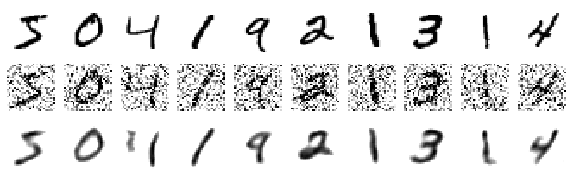

In [11]:
# show sample train images without noise, train images with noice and decoded train images
_, ax = plt.subplots(3, 10, figsize=(10,3))

for i in range(0, 10):
    ax[0,i].axis('off')
    ax[0,i].imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[1,i].axis('off')
    ax[1,i].imshow(train_images_noisy[i].reshape(28,28), cmap=plt.cm.binary)
    ax[2,i].axis('off')
    ax[2,i].imshow(decoded_train_imgs[i].reshape(28,28), cmap=plt.cm.binary)

In [12]:
# get test set
final_test_labels = test_labels
final_test_images = decoded_test_imgs

# get validation set
validation_images = decoded_train_imgs[50000:]
validation_labels = train_labels[50000:]

# get train set
final_train_images = decoded_train_imgs[:50000]
final_train_labels = train_labels[:50000]

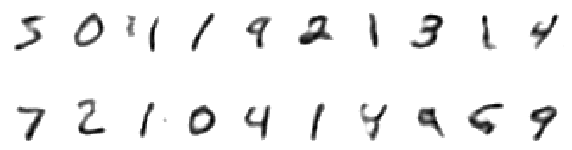

In [13]:
# show sample final_train_images and final_test_images
_, ax = plt.subplots(2, 10, figsize=(10,3))

for i in range(0, 10):
    ax[0,i].axis('off')
    ax[0,i].imshow(final_train_images[i].reshape(28,28), cmap=plt.cm.binary)
    ax[1,i].axis('off')
    ax[1,i].imshow(final_test_images[i].reshape(28,28), cmap=plt.cm.binary)

In [14]:
# function to build a CNN model

def create_model():
    # Convolutional model
    model = models.Sequential()

    # Conv Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    
    # Pool Layer 1
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Pool Layer 2
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Layer 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Flatten Layer 1
    model.add(layers.Flatten())

    # Fully-connected layer 1
    model.add(layers.Dense(64, activation='relu'))
    
    # Fully-connected layer 2
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# build a model
model = create_model()

In [18]:
# Train the model
model.fit(final_train_images, final_train_labels, epochs=10, batch_size=64, validation_data=(validation_images, validation_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 262us/step - loss: 0.1480 - accuracy: 0.9506 - val_loss: 0.1862 - val_accuracy: 0.9409
Epoch 2/10
50000/50000 [==============================] - 15s 309us/step - loss: 0.1355 - accuracy: 0.9544 - val_loss: 0.1899 - val_accuracy: 0.9415
Epoch 3/10
50000/50000 [==============================] - 16s 312us/step - loss: 0.1271 - accuracy: 0.9570 - val_loss: 0.1981 - val_accuracy: 0.9409
Epoch 4/10
50000/50000 [==============================] - 16s 311us/step - loss: 0.1176 - accuracy: 0.9596 - val_loss: 0.2094 - val_accuracy: 0.9422
Epoch 5/10
50000/50000 [==============================] - 16s 310us/step - loss: 0.1079 - accuracy: 0.9633 - val_loss: 0.1928 - val_accuracy: 0.9457
Epoch 6/10
50000/50000 [==============================] - 16s 311us/step - loss: 0.0990 - accuracy: 0.9673 - val_loss: 0.2059 - val_accuracy: 0.9406
Epoch 7/10
50000/50000 [==============================] 

In [19]:
# get accuracy against test set

test_loss, test_acc = model.evaluate(final_test_images, final_test_labels, verbose=1)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

10000/10000 [==============================] - 1s 79us/step
Accuracy: 0.940500020980835
Loss:  0.2148573961596936
